In [1]:
from Libreria.cargar_configbd import cargar_configbd
from Libreria.matriz_de_confusion import matriz_de_confusion

import pandas as pd
import numpy as np
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, classification_report

In [2]:
# Conectar a la base de datos PostgreSQL
conn = cargar_configbd.conectar_base_datos('conf_bd.txt')
cur = conn.cursor()

In [3]:
# -----------------------------------------------------------------------

In [3]:
cur.execute(f"SELECT * FROM datos_uda_reglas;") # Son los viajes etiqetados por toda lo metodologia
# Obtener los resultados de la consulta
rows = cur.fetchall()

df_modos = pd.DataFrame(rows.copy(), columns=[desc[0] for desc in cur.description])

num_elementos_por_grupo = df_modos.groupby('etiqueta').size()
print(num_elementos_por_grupo)

etiqueta
AUTOMOVIL    110
BICICLETA    110
BUS          110
CAMINATA     110
dtype: int64


In [6]:
data = df_modos.copy()

In [7]:
def normalize_data(X):
    scaler = MinMaxScaler()
    X_normalized = scaler.fit_transform(X)
    X_normalized_df = pd.DataFrame(X_normalized, columns=X.columns)
    return X_normalized_df

In [8]:
# Extraer las características (X) y las etiquetas (y) del DataFrame
X = data.iloc[:, 3:-1]  # Todas las filas, todas las columnas excepto la última
#X = normalize_data(data.iloc[:, 3:-1])
y = data.iloc[:, -1]   # Todas las filas, solo la última columna

# Codificar las etiquetas de la variable objetivo
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify=y, random_state=42)
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(X, y_encoded, test_size = test_size, stratify=y, random_state=42)

In [9]:
selected_features = joblib.load('selected_features.joblib')
# Imprime las características seleccionadas en orden de importancia
print(selected_features)

Index(['max_speed', 'mean_time_stop', 'max_time_stop', 'p25_speed',
       'mean_speed', 'p75_time_stop', 'p75_speed', 'var_time_stop',
       'median_time_stop', 'median_speed', 'p25_time_stop', 'stops',
       'p75_aceleration', 'var_bearing', 'min_speed', 'min_time_stop',
       'min_bearing', 'max_aceleration', 'var_speed', 'p25_bearing',
       'max_bearing', 'median_aceleration', 'mean_aceleration', 'p75_bearing',
       'min_aceleration', 'mean_bearing', 'var_aceleration', 'p25_aceleration',
       'median_bearing'],
      dtype='object')


Number of features: 24
Modelo completo guardado en 'complete_model.joblib'
Precisión del modelo en el conjunto de entrenamiento: 0.9737654320987654
Precisión del modelo en el conjunto de prueba: 0.9107142857142858


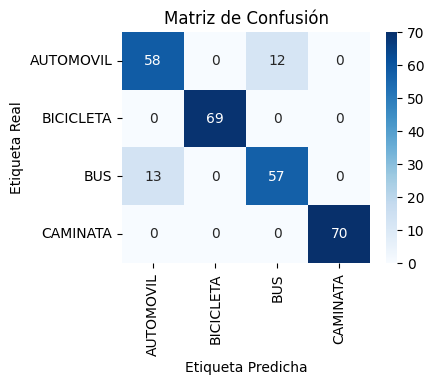


Classification Report for the Best Model:
              precision    recall  f1-score   support

   AUTOMOVIL       0.82      0.83      0.82        70
   BICICLETA       1.00      1.00      1.00        69
         BUS       0.83      0.81      0.82        70
    CAMINATA       1.00      1.00      1.00        70

    accuracy                           0.91       279
   macro avg       0.91      0.91      0.91       279
weighted avg       0.91      0.91      0.91       279



In [9]:
number_of_features = 24 #11
print(f"Number of features: {number_of_features}")

for number_of_features in range(2, 29)

#classifier = SVC(C=100, gamma=0.1, kernel='rbf')
classifier = RandomForestClassifier(max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, random_state=42)
#classifier = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_leaf=4, min_samples_split=2, random_state=42)

classifier.fit(X_train[selected_features[:number_of_features]], y_train)

# Guardar modelo
modelo_completo = {
    'number_of_features': number_of_features,
    'label_encoder': label_encoder,
    'selected_features': selected_features,
    'classifier': classifier
}
joblib.dump(modelo_completo, 'complete_model.joblib')
print(f"Modelo completo guardado en 'complete_model.joblib'")

y_test_pred = classifier.predict(X_test[selected_features[:number_of_features]])
y_train_pred = classifier.predict(X_train[selected_features[:number_of_features]])

# Calcular el accuracy para conjuntos de entrenamiento y prueba
train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
test_accuracy = balanced_accuracy_score(y_test, y_test_pred)

print("Precisión del modelo en el conjunto de entrenamiento:", train_accuracy)
print("Precisión del modelo en el conjunto de prueba:", test_accuracy)

# Calcular y mostrar la matriz de confusión
matriz_de_confusion.heatmap(y_test, y_test_pred)

# Calcular y mostrar el reporte de clasificación
class_report_best = classification_report(y_test, y_test_pred)
print("\nClassification Report for the Best Model:")
print(class_report_best)

In [10]:
if isinstance(classifier, DecisionTreeClassifier):    
    # Extraer y mostrar las reglas del árbol de decisión
    tree_rules = export_text(classifier, feature_names=selected_features[:number_of_features])
    print(tree_rules)
else:
        # Acceder a los árboles en el bosque
        estimators = classifier.estimators_

        for estimator in estimators:
            # Extraer reglas en formato de texto
            rules = export_text(estimator, feature_names=selected_features[:number_of_features])
            print(rules)

|--- mean_time_stop <= 33.75
|   |--- var_speed <= 5.35
|   |   |--- mean_aceleration <= 0.01
|   |   |   |--- max_speed <= 5.26
|   |   |   |   |--- class: 3.0
|   |   |   |--- max_speed >  5.26
|   |   |   |   |--- class: 1.0
|   |   |--- mean_aceleration >  0.01
|   |   |   |--- p75_speed <= 7.01
|   |   |   |   |--- stops <= 24.50
|   |   |   |   |   |--- class: 1.0
|   |   |   |   |--- stops >  24.50
|   |   |   |   |   |--- p25_speed <= 1.49
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- p25_speed >  1.49
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |--- p75_speed >  7.01
|   |   |   |   |--- class: 1.0
|   |--- var_speed >  5.35
|   |   |--- mean_aceleration <= 1.54
|   |   |   |--- p75_aceleration <= 0.46
|   |   |   |   |--- median_time_stop <= 5.50
|   |   |   |   |   |--- class: 2.0
|   |   |   |   |--- median_time_stop >  5.50
|   |   |   |   |   |--- p75_aceleration <= 0.22
|   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |--- p75_aceler